In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

![Image denoising results](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/image_denoise_fmnist_results.png?raw=1)

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random noise to the images

In [4]:
# Fn para agregar ruido sal y pimienta
def add_salt_n_pepper(img, noise_factor):
    img_out = tf.identity(img)
    
    umbral = 1 - noise_factor
    ruido = tf.random.uniform(shape=tf.shape(img), minval=0., maxval=1.)
    
    #sal
    img_out = tf.where(ruido < noise_factor, 1.0, img_out)
    
    #pimienta
    img_out = tf.where(ruido > umbral, 0.0, img_out)
    
    return img_out

# noise_factor de ruido
noise_factor = 0.05

# Aplicar ruido sal y pimienta
x_train_noisy = add_salt_n_pepper(x_train, noise_factor)
x_test_noisy = add_salt_n_pepper(x_test, noise_factor)

# Asegurarse de que los valores estén en el rango correcto
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)


In [5]:
'''noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)'''

'noise_factor = 0.2\nx_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)\nx_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)\n\nx_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)\nx_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)'

Plot the noisy images.


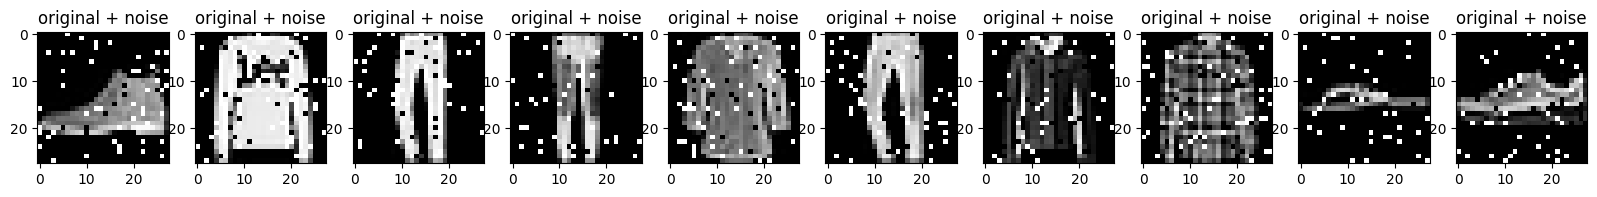

In [6]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=3,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [ ]:
autoencoder.encoder.summary()

The decoder upsamples the images back from 7x7 to 28x28.

In [ ]:
autoencoder.decoder.summary()

Plotting both the noisy images and the denoised images produced by the autoencoder.

In [ ]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()